In [1]:
import sys
root = '/home/featurize/data'
sys.path.append(f'{root}/pikachu/utils')
sys.path.append(f'{root}/pikachu/third')
sys.path.append(f'{root}/pikachu')
sys.path.append(f'{root}/pikachu/projects/ai/naic_seg')

In [2]:
import os
import gezi
from gezi import tqdm
import melt as mt
import numpy as np
import cv2
import glob
import tensorflow as tf

In [3]:
model_path = '/home/featurize/data/submit_v1/model.h5'
model = mt.load_model(model_path)

In [4]:
model.summary()

Model: "sm.Unet_EfficientNetB4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_ResizeBilinear (Ten (None, 288, 288, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_Reshape (TensorFlow (None, 288, 288, 3)  0           tf_op_layer_ResizeBilinear[0][0] 
__________________________________________________________________________________________________
tf_op_layer_ReverseV2 (TensorFl (None, 288, 288, 3)  0           tf_op_layer_Reshape[0][0]        
_____________________________________________________________________________

In [20]:
# 这个混入了v1训练数据swa
model2 = mt.load_model('/home/featurize/work/naicseg/v9/abc/sm.Unet.EfficientNetB4.augl3.size256.200epoch.mix.swa50/model_tta.h5')

In [29]:
model3 = mt.load_model('/home/featurize/work/naicseg/v9/abc/sm.Unet.EfficientNetB4.augl3.size256.200epoch.mix.swa50/model.h5')

In [30]:
model3.summary()

Model: "sm.Unet_EfficientNetB4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF (None, 256, 256, 3)       0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF (None, 256, 256, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso (None, 256, 256, 3)       0         
_________________________________________________________________
sm-unet-efficientnetb4 (Func [(None, 256, 256, 15), (N 23092895  
_________________________________________________________________
tf_op_layer_Reshape (TensorF (None, 256, 256, 15)      0         
Total params: 23,092,895
Trainable params: 22,966,703
Non-trainable params: 126,192
__________________________

In [5]:
img = gezi.imread('../input/eval.naic.v1/image/187676.tif')

In [6]:
CLASSES = ['water', 'track', 'build', 'arable', 'grass', 'forest', 'bare', 'other']
CLASSES_V2 = ['water', 'track_road', 'build', 'track_airport', 'other_park', 'other_playground', 
            'arable_natural', 'arable_greenhouse',
            'grass_natural', 'grass_greenbelt', 
            'forest_natural', 'forest_planted', 
            'bare_natural', 'bare_planted', 'other_other']

In [17]:
# 注意label对应的class展示不对 不过不影响其他
def vis_pred_dv1(x, index, root_dir='../input/eval.naic.v1'):
  label = (cv2.imread(f'{root_dir}/label/{index}.png', cv2.IMREAD_UNCHANGED) / 100 - 1).astype(np.uint8)
  gezi.plot.segmentation_eval_logits(
            cv2.imread(f'{root_dir}/image/{index}.tif'),
            label,
            x,
            CLASSES_V2,
        )

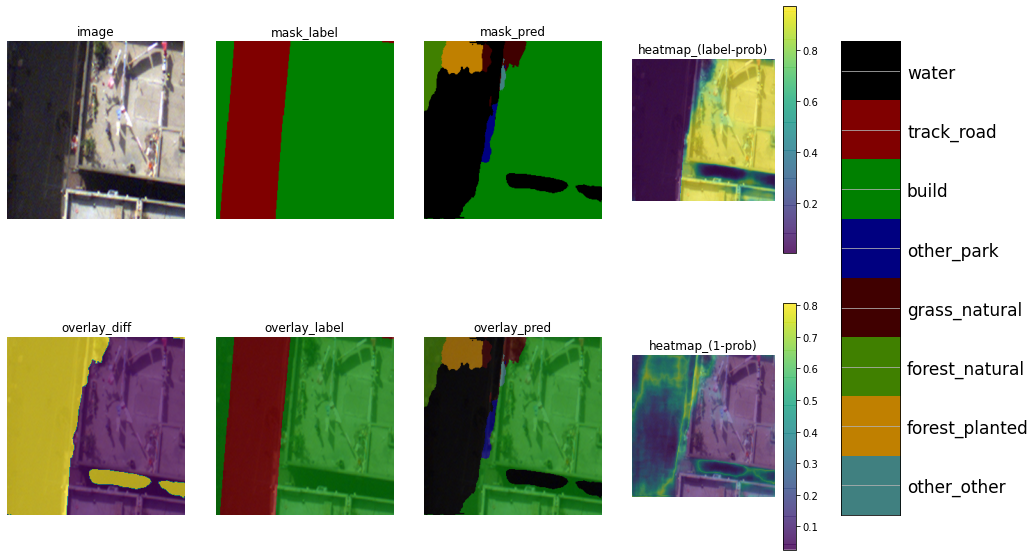

In [26]:
index = 121116
index = 265144
index = 316267
index = 378248
img = gezi.imread(f'../input/eval.naic.v1/image/{index}.tif')
res = model.predict(np.asarray([img]))[0]
vis_pred_dv1(res, index, root_dir='../input/eval.naic.v1')

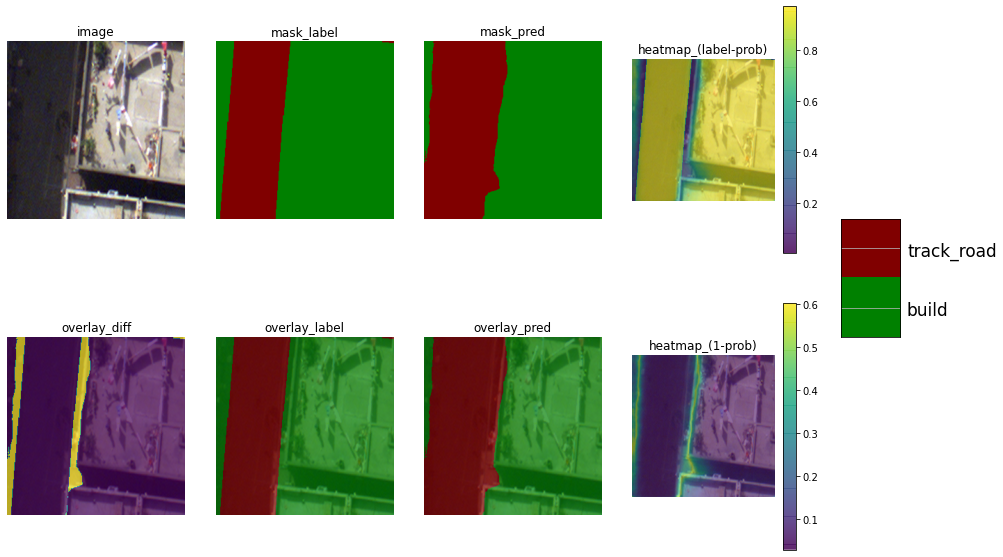

In [27]:
index = 121116
index = 265144
index = 316267
index = 378248
img = gezi.imread(f'../input/eval.naic.v1/image/{index}.tif')
res = model2.predict(np.asarray([img]))[0]
vis_pred_dv1(res, index, root_dir='../input/eval.naic.v1')

In [44]:
def _predict(model, imgs, tta=False):
  if not tta:
    pred = model.predict(imgs)
  else:
    imgs_list = [imgs, tf.image.flip_left_right(imgs), tf.image.flip_up_down(imgs)]
    imgs = tf.concat(imgs_list, axis=0)
    res = np.split(model.predict(imgs), len(imgs_list))
    res[1] = tf.image.flip_left_right(res[1]).numpy()
    res[2] = tf.image.flip_up_down(res[2]).numpy()
    # pred = np.mean(res, axis=0)
    pred = (res[0] + res[1] + res[2]) / 3.
  return pred
    
def predicts(model, indir='../input/eval.naic/image', odir='../input/out', batch_size=16, tta=False, num_imgs=0):
  gezi.try_mkdir(odir)
  os.system(f'rm -rf {odir}/*')
  img_paths = glob.glob(f'{indir}/*')
  num_imgs = num_imgs or len(img_paths)
  for i in tqdm(range(0, num_imgs, batch_size), desc='predict', ascii=True, leave=True):
    begin = i
    end = min(i + batch_size, num_imgs)
    imgs = np.asarray([gezi.imread(img_path) for img_path in img_paths[begin:end]])
    logits = _predict(model, imgs, tta)
    preds = logits.argmax(-1)
    for img_path, pred in zip(img_paths[begin:end], preds):
      index = os.path.basename(img_path).split('.')[0]
      cv2.imwrite(os.path.join(odir, f'{index}.png'), pred)

In [47]:
predicts(model, num_imgs=1000)

In [48]:
predicts(model, num_imgs=1000, batch_size=1)

In [49]:
predicts(model, num_imgs=1000, batch_size=4)

In [50]:
predicts(model2, odir='../input/out2', num_imgs=1000)

In [51]:
predicts(model2, odir='../input/out2', num_imgs=1000, batch_size=1)

In [53]:
predicts(model2, odir='../input/out2', num_imgs=1000, batch_size=4)

In [54]:
predicts(model3, odir='../input/out3', num_imgs=1000)

In [55]:
predicts(model3, odir='../input/out3', num_imgs=1000, batch_size=1)

In [56]:
predicts(model3, odir='../input/out3', num_imgs=1000, batch_size=4)

In [39]:
predicts(model3, odir='../input/out4', tta=True)